In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.13.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Mini ProjectRisk Msc DS/Main Project/NER/Dataset/NER dataset.csv', encoding='utf-8')
df = df.fillna(method='ffill')
df.head(-5)

,Word,POS,Sentence Id,Tag
0,Chinese,JJ,1,O
1,tech,NN,1,O
2,giant,NN,1,O
3,Alibaba,NNP,1,B-IDENTITY
4,has,VBZ,1,O
...,...,...,...,...
204805,wipers,NNS,6311,O
204806,that,WDT,6311,O
204807,have,VBP,6311,O
204808,been,VBN,6311,O


In [4]:
df['Sentence Id'].nunique(), df.Word.nunique(), df.Tag.nunique()

(6311, 16201, 25)

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['ner_tags'] = le.fit_transform(df['Tag'])
df['ner_tags'] = df['ner_tags'] + 1

In [6]:
df.groupby('ner_tags').size().reset_index(name='counts')

,ner_tags,counts
0,1,127
1,2,715
2,3,108
3,4,968
4,5,3972
5,6,345
6,7,348
7,8,1431
8,9,1111
9,10,470


In [7]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["ner_tags"].values.tolist())]
        self.grouped = self.data.groupby("Sentence Id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(df)

In [9]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Chinese',
 'tech',
 'giant',
 'Alibaba',
 'has',
 'reportedly',
 'been',
 'shunned',
 'by',
 'Chinas',
 'top',
 'tech',
 'regulator',
 'for',
 'failing',
 'to',
 'report',
 'the',
 'infamous',
 'Log4j',
 'vulnerability',
 'quickly',
 'enough',
 '.']

In [10]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

[25, 25, 25, 5, 25, 25, 25, 25, 25, 8, 25, 25, 25, 25, 25, 25, 25, 25, 25, 11, 25, 25, 25, 25]


In [11]:
def split_tokens_and_labels(tokens_list, labels_list, max_length=75):
    new_tokens_list = []
    new_labels_list = []

    for tokens, labels in zip(tokens_list, labels_list):
        if len(tokens) <= max_length:
            new_tokens_list.append(tokens)
            new_labels_list.append(labels)
        else:
            start = 0
            end = max_length
            while start < len(tokens):
                new_tokens_list.append(tokens[start:end])
                new_labels_list.append(labels[start:end])
                start = end
                end = start + max_length

    return new_tokens_list, new_labels_list



In [12]:
new_tokens_list, new_labels_list = split_tokens_and_labels(sentences, labels, max_length=75)

Preprocess the sentence and labels. prepare to use with pytorch and bert

In [15]:
pip install transformers

In [16]:
pip install pytorch-crf

In [17]:
# @title
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import  TokenClassifierOutput
from torch import nn
from torch.nn import CrossEntropyLoss
import torch
from torchcrf import CRF

In [18]:
# @title
class BertCRF(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.crf = CRF(num_tags=config.num_labels, batch_first=True)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            log_likelihood, tags = self.crf(logits, labels), self.crf.decode(logits)
            loss = 0 - log_likelihood
        else:
            tags = self.crf.decode(logits)
        tags = torch.Tensor(tags)

        if not return_dict:
            output = (tags,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return loss, tags

In [19]:
!pip install datasets
!pip install transformers[torch]
!pip install accelerate>=0.20.1

In [20]:
from datasets import Dataset
data = {
    'tokens': new_tokens_list,
    'ner_tags': new_labels_list
}
dataset = Dataset.from_dict(data)

In [21]:
from sklearn.metrics import classification_report, f1_score
from transformers import BertTokenizerFast, Trainer, TrainingArguments,BertTokenizer
from transformers.trainer_utils import IntervalStrategy
from sklearn.model_selection import train_test_split


train_dataset, test_dataset = train_test_split(dataset, test_size = 0.2, random_state = 2018)
train_dataset = Dataset.from_dict(train_dataset)
test_dataset = Dataset.from_dict(test_dataset)

train_dataset = train_dataset.rename_column('ner_tags', 'label_ids')
test_dataset = test_dataset.rename_column('ner_tags', 'label_ids')

In [22]:
model = BertCRF.from_pretrained('bert-base-cased', num_labels=26)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

Some weights of BertCRF were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['crf.transitions', 'crf.end_transitions', 'crf.start_transitions', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    result = {
        'label_ids': [],
        'input_ids': [],
        'token_type_ids': [],
    }
    max_length = tokenizer.max_model_input_sizes['bert-base-cased']

    for tokens, label in zip(batch['tokens'], batch['label_ids']):
        tokenids = tokenizer(tokens, add_special_tokens=False)

        token_ids = []
        label_ids = []
        for ids, lab in zip(tokenids['input_ids'], label):
            #lab = int(lab)  # Convert lab to an integer
            if len(ids) > 1 and lab % 2 == 1:
                token_ids.extend(ids)
                chunk = [lab] * len(ids)
                chunk[0] = lab
                label_ids.extend(chunk)
            else:
                token_ids.extend(ids)
                chunk = [lab] * len(ids)
                label_ids.extend(chunk)

        token_type_ids = tokenizer.create_token_type_ids_from_sequences(token_ids)
        token_ids = tokenizer.build_inputs_with_special_tokens(token_ids)
        label_ids.insert(0, 0)
        label_ids.append(0)
        result['input_ids'].append(token_ids)
        result['label_ids'].append(label_ids)
        result['token_type_ids'].append(token_type_ids)

    result = tokenizer.pad(result, padding='longest', max_length=max_length, return_attention_mask=True, )
    for i in range(len(result['input_ids'])):
        diff = len(result['input_ids'][i]) - len(result['label_ids'][i])
        result['label_ids'][i] += [0] * diff
    return result


train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))
train_dataset.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label_ids'])
test_dataset.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label_ids'])


def compute_metrics(pred):
    labels = pred.label_ids.flatten()
    preds = pred.predictions.flatten()
    f1 = f1_score(labels, preds, average='macro')
    print(classification_report(labels, preds))
    return {
        'f1': f1
    }


In [ ]:
from transformers import TrainingArguments, Trainer, AdamW, get_scheduler, EarlyStoppingCallback


learning_rate = 3e-5
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.01,
)

num_warmup_steps = 200

scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(train_dataset) // 64 * 3,
)

model.optimizer = optimizer
model.lr_scheduler = scheduler

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    save_strategy=IntervalStrategy.EPOCH,
    evaluation_strategy=IntervalStrategy.EPOCH,
    logging_dir='./logs',

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False, 
    report_to="tensorboard", 
    run_name="my_experiment",
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)], 
)


trainer.train()

results = trainer.evaluate()
print(results)


# Test Data

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

true_label = []
predictions = []
model.to(device)
        
with torch.no_grad():
            
  outputs = model(test_dataset['input_ids'].to(device), token_type_ids=None,
                            attention_mask=test_dataset['attention_mask'].to(device), labels=test_dataset['label_ids'].to(device))
      
logits = outputs[1].detach().cpu().numpy()
label_ids = test_dataset['label_ids'].to('cpu').numpy()

predictions = list(logits.flatten())
true_label = list(label_ids.flatten())

In [29]:
pred_tags = [p for p, l in zip(predictions, true_label) if l!=0 and p!=0]
true_test_tags = [l for p, l in zip(predictions, true_label) if l!=0 and p!=0]

In [30]:
pred_ = [int(x - 1) for x in pred_tags]
true_ = [int(x - 1) for x in true_test_tags]

In [31]:
pred_ = le.inverse_transform(pred_)
true_ = le.inverse_transform(true_)

In [32]:
p = []
t = []
for i in pred_:
  if i == 'O':
    p.append(i)
  else:
    p.append(i[2:])

for i in true_:
  if i == 'O':
    t.append(i)
  else:
    t.append(i[2:])

In [33]:
from sklearn.metrics import classification_report
print(classification_report(true_, pred_))

                  precision    recall  f1-score   support

         B-ASSET       0.45      0.52      0.48        65
   B-ATTACK_TYPE       0.73      0.88      0.80       375
      B-CAMPAIGN       0.75      0.69      0.72        71
     B-DATE_TIME       0.88      0.90      0.89       267
      B-IDENTITY       0.77      0.82      0.79      1423
     B-INDICATOR       0.84      0.84      0.84       278
B-INFRASTRUCTURE       0.69      0.59      0.63       123
      B-LOCATION       0.86      0.87      0.87       355
       B-MALWARE       0.84      0.89      0.87       537
  B-THREAT_ACTOR       0.80      0.76      0.78       224
          B-TOOL       0.71      0.77      0.74       442
 B-VULNERABILITY       0.41      0.67      0.51        18
         I-ASSET       0.74      0.67      0.71        43
   I-ATTACK_TYPE       0.78      0.49      0.60        57
      I-CAMPAIGN       0.87      0.76      0.81        54
     I-DATE_TIME       0.88      0.92      0.90        83
      I-IDENT

In [34]:
from sklearn.metrics import classification_report
print(classification_report(t, p))

                precision    recall  f1-score   support

         ASSET       0.55      0.58      0.57       108
   ATTACK_TYPE       0.78      0.88      0.83       432
      CAMPAIGN       0.80      0.72      0.76       125
     DATE_TIME       0.92      0.94      0.93       350
      IDENTITY       0.78      0.80      0.79      2064
     INDICATOR       0.86      0.88      0.87       310
INFRASTRUCTURE       0.71      0.57      0.63       149
      LOCATION       0.89      0.88      0.88       397
       MALWARE       0.85      0.91      0.88       627
             O       0.98      0.98      0.98     45505
  THREAT_ACTOR       0.75      0.79      0.77       259
          TOOL       0.72      0.71      0.72       514
 VULNERABILITY       0.57      0.62      0.60        40

      accuracy                           0.96     50880
     macro avg       0.78      0.79      0.78     50880
  weighted avg       0.96      0.96      0.96     50880



In [35]:
report = classification_report(t, p, digits=4, output_dict=True)
f1_weighted = report['weighted avg']['f1-score']

recall_weighted = report['weighted avg']['recall']
precision_weighted = report['weighted avg']['precision']

# Print the results

print ('Weighted F1 Score: ', f1_weighted)
print ('Weighted Recall: ', recall_weighted)
print ('Weighted Precision: ', precision_weighted)

Weighted F1 Score:  0.9614494503808914
Weighted Recall:  0.9612814465408805
Weighted Precision:  0.9617845800557793


In [36]:
report = classification_report(t, p, digits=4, output_dict=True)
f1_weighted = report['macro avg']['f1-score']

recall_weighted = report['macro avg']['recall']
precision_weighted = report['macro avg']['precision']

# Print the results

print ('Macro F1 Score: ', f1_weighted)
print ('Macro Recall: ', recall_weighted)
print ('Macro Precision: ', precision_weighted)

Macro F1 Score:  0.7839325716885367
Macro Recall:  0.7897667442661548
Macro Precision:  0.7807296021835105


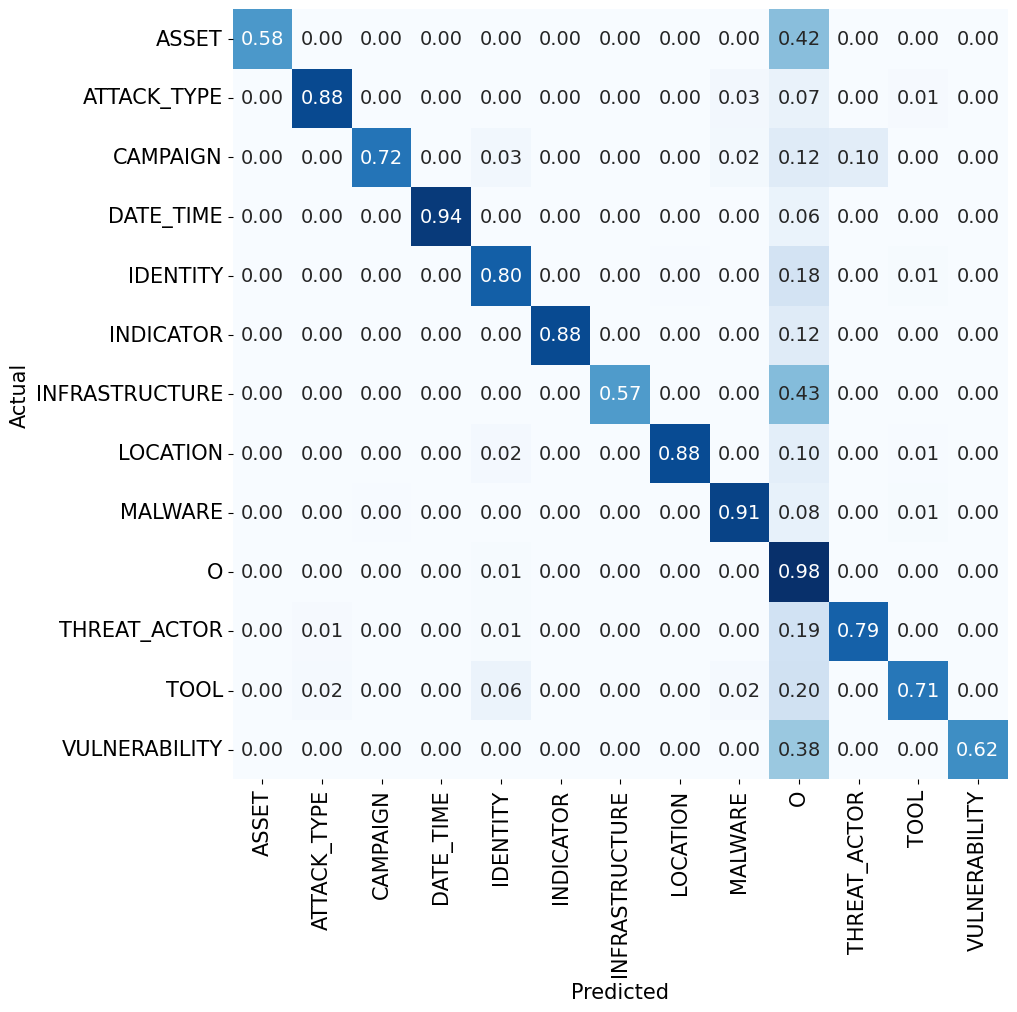

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm_array = confusion_matrix(t, p)

cm_normalized = cm_array.astype('float') / cm_array.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))

cm_array_df = pd.DataFrame(cm_normalized, index=np.unique(p), columns=np.unique(p))
annot_font_size = 14 
annot_kws = {'size': annot_font_size}

sns.heatmap(cm_array_df, annot=True, cbar=False, fmt='.2f', cmap='Blues', ax=ax, annot_kws=annot_kws)
ax.set_xlabel('Predicted', fontsize=15)
ax.set_ylabel('Actual', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)  
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
plt.show()


# Case Study

In [37]:
lis = list(range(25))
id2label = list(le.inverse_transform(lis))
id2label.insert(0,'[PAD]')

In [39]:
model1 = BertCRF.from_pretrained('./results/checkpoint-343', num_labels=26)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

def decode(label_ids, input_ids, offsets_mapping, id2label):
    result = []
    for k in range(len(label_ids)):
        words = []
        labels = []
        for i in range(len(label_ids[k])):
            start_ind, end_ind = offset_mapping[k][i]
            word = tokenizer.convert_ids_to_tokens([int(input_ids[k][i])])[0]
            is_subword = end_ind - start_ind != len(word)
            if is_subword:
                if word.startswith('##'):
                    words[-1] += word[2:]
            else:
                words.append(word)
                labels.append(id2label[int(label_ids[k][i])])
        result.append(
            {'words': words,
             'labels': labels}
        )
    return result


corpus = ['In October 2022, we identified an active infection of government, agriculture\
 and transportation organizations located in the Donetsk, Lugansk, and Crimea regions. Although the initial vector of compromise is unclear, the details of the next stage imply the use of spear phishing or similar methods.\
 The victims navigated to a URL pointing to a ZIP archive hosted on a malicious web server.'
]

inputs = tokenizer(corpus, max_length=512, padding=True, truncation=True, return_tensors='pt',
                   return_offsets_mapping=True)
offset_mapping = inputs.pop("offset_mapping").cpu().numpy().tolist()

outputs = model1(**inputs)
result = decode(outputs[1].numpy().tolist(), inputs['input_ids'].numpy().tolist(), offset_mapping, id2label)
for token, label in zip(result[0]['words'], result[0]['labels']):
    print("{:20}\t{}".format(token, label))

In                  	O
October             	B-DATE_TIME
2022                	I-DATE_TIME
,                   	O
we                  	O
identified          	O
an                  	O
active              	O
infection           	O
of                  	O
government          	B-IDENTITY
,                   	O
agriculture         	O
and                 	O
transportation      	O
organizations       	O
located             	O
in                  	O
the                 	O
Donetsk             	B-LOCATION
,                   	O
Lugansk             	B-LOCATION
,                   	O
and                 	O
Crimea              	B-LOCATION
regions             	O
.                   	O
Although            	O
the                 	O
initial             	O
vector              	O
of                  	O
compromise          	O
is                  	O
unclear             	O
,                   	O
the                 	O
details             	O
of                  	O
the                 	O
next                	O
s